<ipython-input-2-e148d1f8710d>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


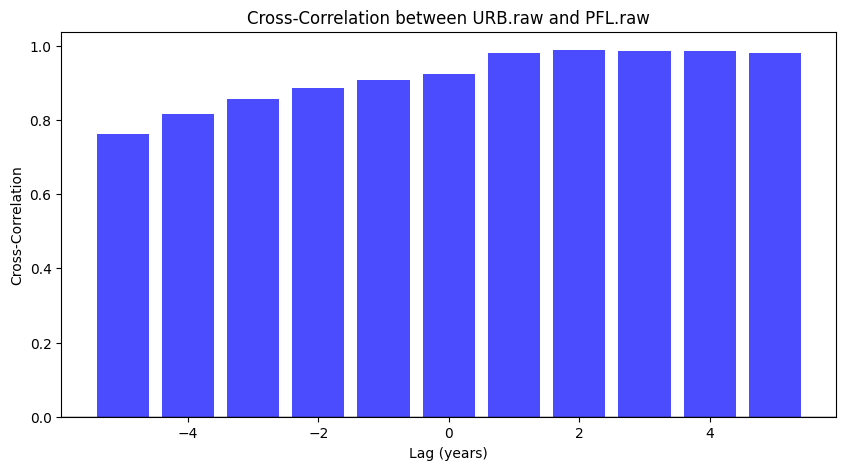

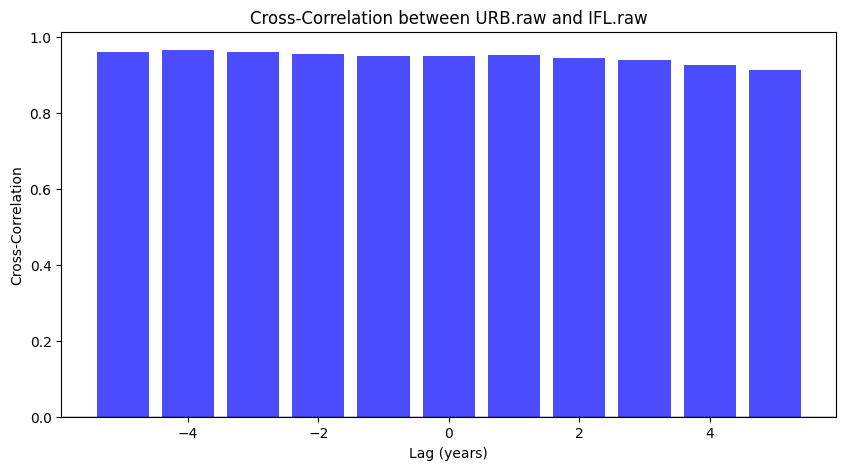

Best lag for URB-PFL: 2 years with correlation 0.989
Best lag for URB-IFL: -4 years with correlation 0.966


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
<ipython-input-2-e148d1f8710d>:83: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(start=series.index[-1], periods=forecast_years+1, freq='Y')[1:],


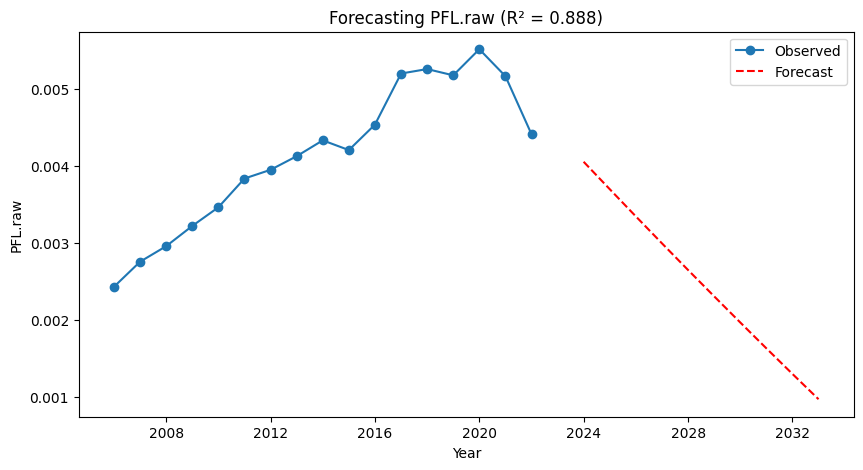

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
<ipython-input-2-e148d1f8710d>:83: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plt.plot(pd.date_range(start=series.index[-1], periods=forecast_years+1, freq='Y')[1:],


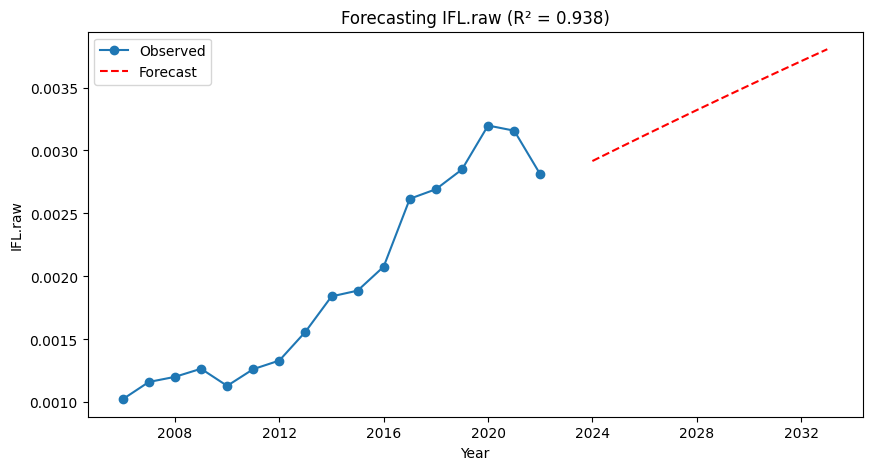

R² for PFL Forecast: 0.888
R² for IFL Forecast: 0.938


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing

# Load datasets
pfl = pd.read_csv("clean_PFL.csv")
ifl = pd.read_csv("clean_IFL.csv")
urb = pd.read_csv("clean_URB.csv")

# Reshape datasets from wide format to long format
def reshape_data(df, var_name):
    df_long = df.melt(id_vars=["country", "iso"], var_name="year", value_name=var_name)
    df_long["year"] = df_long["year"].str.extract("(\\d{4})").astype(int)  # Extract year from column names
    return df_long

pfl_long = reshape_data(pfl, "PFL.raw")
ifl_long = reshape_data(ifl, "IFL.raw")
urb_long = reshape_data(urb, "URB.raw")

# Merge datasets
data = pfl_long.merge(ifl_long, on=["country", "iso", "year"]).merge(urb_long, on=["country", "iso", "year"])

# Filter to common years (2006-2022)
data = data[(data["year"] >= 2006) & (data["year"] <= 2022)]

# Handle missing values
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)

# Ensure only numeric columns are included for aggregation
numeric_cols = ["PFL.raw", "IFL.raw", "URB.raw"]

# Aggregate only numeric columns
yearly_data = data.groupby("year")[numeric_cols].mean()

# Convert index to datetime format for forecasting
yearly_data.index = pd.to_datetime(yearly_data.index, format='%Y')

# Align datasets to common years (2006-2022)
common_years = yearly_data.index
yearly_data = yearly_data.loc[common_years]
urb_series = yearly_data["URB.raw"]
pfl_series = yearly_data["PFL.raw"]
ifl_series = yearly_data["IFL.raw"]

# Cross-Correlation Analysis
def cross_corr_analysis(series1, series2, max_lag=5):
    """Computes cross-correlation between two time series with proper alignment."""
    lags = np.arange(-max_lag, max_lag + 1)
    correlations = [series1.corr(series2.shift(lag)) for lag in lags]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.bar(lags, correlations, color="blue", alpha=0.7)
    plt.axhline(0, color="black", linewidth=1)
    plt.xlabel("Lag (years)")
    plt.ylabel("Cross-Correlation")
    plt.title(f"Cross-Correlation between {series1.name} and {series2.name}")
    plt.show()

    return lags[np.argmax(np.abs(correlations))], max(correlations, key=abs)

# Perform cross-correlation with aligned data
best_lag_pfl, max_corr_pfl = cross_corr_analysis(urb_series, pfl_series)
best_lag_ifl, max_corr_ifl = cross_corr_analysis(urb_series, ifl_series)

print(f"Best lag for URB-PFL: {best_lag_pfl} years with correlation {max_corr_pfl:.3f}")
print(f"Best lag for URB-IFL: {best_lag_ifl} years with correlation {max_corr_ifl:.3f}")

# Forecasting Future Forest Loss using Exponential Smoothing
def forecast_exponential_smoothing(series, forecast_years=10):
    """Applies Holt's Linear Trend Exponential Smoothing to forecast future values."""
    model = ExponentialSmoothing(series, trend="add", seasonal=None, damped_trend=True)
    fit = model.fit()
    forecast = fit.forecast(forecast_years)
    r2 = 1 - (np.sum((series - fit.fittedvalues) ** 2) / np.sum((series - np.mean(series)) ** 2))  # Compute R-squared

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(series.index, series, label="Observed", marker="o")
    plt.plot(pd.date_range(start=series.index[-1], periods=forecast_years+1, freq='Y')[1:],
             forecast, label="Forecast", linestyle="dashed", color="red")
    plt.xlabel("Year")
    plt.ylabel(series.name)
    plt.title(f"Forecasting {series.name} (R² = {r2:.3f})")
    plt.legend()
    plt.show()

    return forecast, r2

# Forecasting Primary Forest Loss (PFL) and Intact Forest Loss (IFL)
forecast_pfl, r2_pfl = forecast_exponential_smoothing(pfl_series)
forecast_ifl, r2_ifl = forecast_exponential_smoothing(ifl_series)

print(f"R² for PFL Forecast: {r2_pfl:.3f}")
print(f"R² for IFL Forecast: {r2_ifl:.3f}")